In [ ]:
!pip install -q datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.5 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import torch

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:

task="zero-shot-classification"
model="google/gemma-7b"
classifier=pipeline(task,model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")
dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
test_data = dataset["test"]

# Check if the number of rows in the test set is less than 5000
if test_data.num_rows < 100:
    print("Warning: Test set has less than 5000 samples. Taking all available samples.")
    sampled_data = test_data
else:
    # Take 5000 random samples using shuffle and select
    sampled_data = test_data.shuffle(seed=43).select(range(100))

In [ ]:
sampled_data

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})

In [ ]:
from collections import Counter
# Count the occurrences of label 1 and label 0
label_counts = Counter([data["label"] for data in sampled_data])

# Extract the counts for label 1 and label 0
num_label_1 = label_counts[1]
num_label_0 = label_counts[0]

print(f"Number of label 1 (positive): {num_label_1}")
print(f"Number of label 0 (negative): {num_label_0}")

Number of label 1 (positive): 50
Number of label 0 (negative): 50


In [ ]:
sampled_data["text"]

['I cannot hate on the show. When the old (and better) tech TV had to hit the bricks, the channel was reformatted and new shows stepped in. "Attack of the Show" is the replacement for the Screen Savers, with 3 co-hosts in the beginning. They were Kevin Rose, Kevin Pereira and Sarah Lane. Brendan Moran came to be something of a co-host as well, but he mostly did prerecorded pieces for the show. Kevin Rose decided to leave the show, and eventually there was a contest to see who would be the third host, but that didn\'t pan out for some reason.<br /><br />Eventually (I just learned this from this very IMDb messageboard) Sarah Lane and Brendan Moran moved on because (hey, this is what I read) the two got married. That was a big secret to me! Now there is a new female co-host, the not-as-hot (my opinion) Olivia Munn. She\'s hiding something in those tops she wears, while Sarah Lane had a perfect body and she wasn\'t afraid to show it.<br /><br />AHEM! Sorry.<br /><br />"Attack of the Show" 

In [ ]:
candidate_labels=["Positive","Negative"]
sequences=["I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have to always say Gene Roddenberry's Earth... otherwise people would not continue watching. Roddenberry\'s ashes must be turning in their orbit as this dull, cheap, poorly edited (watching it without advert breaks really brings this home) trudging Trabant of a show lumbers into space. Spoiler. So, kill off a main character. And then bring him back as another actor. Jeeez! Dallas all over again"]
results=classifier(sequences, candidate_labels)
print(results[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': "I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's rubbish as they

In [ ]:
dataset_labels={
    "Positive":1,
    "Negative":0
}
candidate_labels=list(dataset_labels.keys())
sequences=sampled_data["text"]
true_labels=sampled_data["label"]

In [ ]:
results=classifier(sequences, candidate_labels)

In [ ]:
pred_labels=[dataset_labels[result['labels'][0]] for result in results]

In [ ]:
evaluation = classification_report(y_true=true_labels, y_pred=pred_labels, target_names=candidate_labels)
print(evaluation)

              precision    recall  f1-score   support

    Positive       0.55      0.58      0.56        50
    Negative       0.55      0.52      0.54        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100



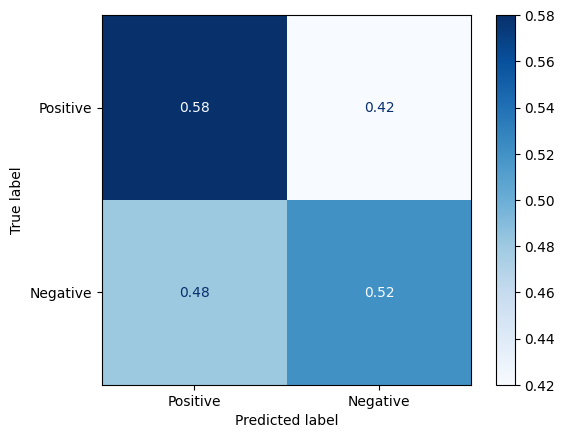

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true=true_labels,
    y_pred=pred_labels,
    display_labels=candidate_labels,
    cmap="Blues",
    normalize="true"
)

In [ ]:
import numpy as np
import math
from tqdm.notebook import tqdm

In [ ]:
candidate_labels = ["Positive","Negative"]
predictions = []
for offset in tqdm(range(math.ceil(len(sampled_data)/16))):
    preds = classifier([sampled_data[16*offset+i]["text"] for i in range(16) if 16*offset+i<len(sampled_data)], candidate_labels)
    pred_labels = [pred["labels"][np.argmax(pred["scores"])] for pred in preds]
    predictions.extend([candidate_labels.index(pred_label) for pred_label in pred_labels])

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(classification_report([x["label"] for x in sampled_data], predictions))

              precision    recall  f1-score   support

           0       0.30      0.12      0.17        50
           1       0.45      0.72      0.55        50

    accuracy                           0.42       100
   macro avg       0.38      0.42      0.36       100
weighted avg       0.38      0.42      0.36       100



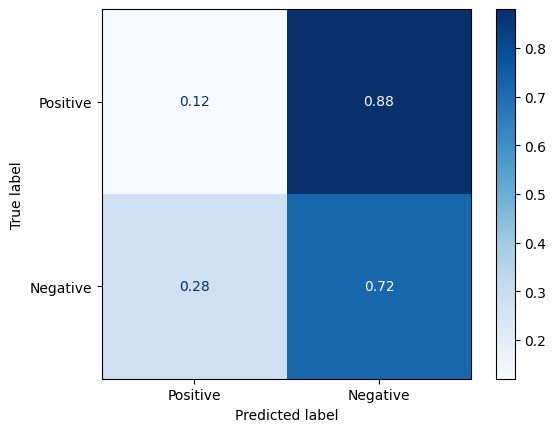

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true=true_labels,
    y_pred=predictions,
    display_labels=candidate_labels,
    cmap="Blues",
    normalize="true"
)